# Detecting Human Activities Through Smartphone Sensor - Training

## Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import glob
from tqdm import tqdm
import seaborn as sns
import filecmp
from sklearn.preprocessing import MaxAbsScaler
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import warnings
from sklearn.ensemble import RandomForestClassifier
import pydot
from IPython.display import Image
from mlxtend import plotting
from six import StringIO
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

## Global Variables

In [2]:
PBAR_FORMAT='{desc:12}{percentage:3.0f}%|{bar:27}[ {n:4d}/{total:4d}, {elapsed}<{remaining}{postfix} ]'

ACTIVITY_CODES_MAP = {'A': 'walking',
                          'B': 'jogging',
                          'C': 'stairs',
                          'D': 'sitting',
                          'E': 'standing',
                          'F': 'typing',
                          'G': 'brushing teeth',
                          'H': 'eating soup',
                          'I': 'eating chips',
                          'J': 'eating pasta',
                          'K': 'drinking from cup',
                          'L': 'eating sandwich',
                          'M': 'kicking soccer ball',
                          'O': 'playing catch tennis ball',
                          'P': 'dribbling basket ball',
                          'Q': 'writing',
                          'R': 'clapping',
                          'S': 'folding clothes'}

ACTIVITY_NAMES = ["walking", "jogging", "stairs", "sitting", "standing", "typing", "brushing teeth",
                  "eating soup", "eating chips", "eating pasta", "drinking from cup", "eating sandwich",
                  "kicking soccer ball", "playing catch tennis ball", "dribbling basket ball",
                  "writing", "clapping", "folding clothes"]

# csv file column names
COL_NAMES =  ['id' , 'activity_code' , 'timestamp', 'x', 'y', 'z']
# training verbose
VERBOSE = 1
# rnadom state for split
RANDOM_STATE=12345

## Extracted Features

In [3]:
features = ['ACTIVITY',
            'X0', # 1st bin fraction of x axis acceleration distribution
            'X1', # 2nd bin fraction ...
            'X2',
            'X3',
            'X4',
            'X5',
            'X6',
            'X7',
            'X8',
            'X9',
            'Y0', # 1st bin fraction of y axis acceleration distribution
            'Y1', # 2nd bin fraction ...
            'Y2',
            'Y3',
            'Y4',
            'Y5',
            'Y6',
            'Y7',
            'Y8',
            'Y9',
            'Z0', # 1st bin fraction of z axis acceleration distribution
            'Z1', # 2nd bin fraction ...
            'Z2',
            'Z3',
            'Z4',
            'Z5',
            'Z6',
            'Z7',
            'Z8',
            'Z9',
            'XAVG', # average sensor value over the window (per axis)
            'YAVG',
            'ZAVG',
            #'PEAK', # Time in milliseconds between the peaks in the wave associated with most activities. heuristically determined (per axis)
            'XABSOLDEV', # Average absolute difference between the each of the 200 readings and the mean of those values (per axis)
            'YABSOLDEV',
            'ZABSOLDEV',
            'XSTANDDEV', # Standard deviation of the 200 window's values (per axis)
            'YSTANDDEV',
            'ZSTANDDEV',
            'XVAR', # Variance of the 200 window's values (per axis)
            'YVAR',
            'ZVAR',
            'XMFCC0', # short-term power spectrum of a wave, based on a linear cosine transform of a log power spectrum on a non-linear mel scale of frequency (13 values per axis)
            'XMFCC1',
            'XMFCC2',
            'XMFCC3',
            'XMFCC4',
            'XMFCC5',
            'XMFCC6',
            'XMFCC7',
            'XMFCC8',
            'XMFCC9',
            'XMFCC10',
            'XMFCC11',
            'XMFCC12',
            'YMFCC0', # short-term power spectrum of a wave, based on a linear cosine transform of a log power spectrum on a non-linear mel scale of frequency (13 values per axis)
            'YMFCC1',
            'YMFCC2',
            'YMFCC3',
            'YMFCC4',
            'YMFCC5',
            'YMFCC6',
            'YMFCC7',
            'YMFCC8',
            'YMFCC9',
            'YMFCC10',
            'YMFCC11',
            'YMFCC12',
            'ZMFCC0', # short-term power spectrum of a wave, based on a linear cosine transform of a log power spectrum on a non-linear mel scale of frequency (13 values per axis)
            'ZMFCC1',
            'ZMFCC2',
            'ZMFCC3',
            'ZMFCC4',
            'ZMFCC5',
            'ZMFCC6',
            'ZMFCC7',
            'ZMFCC8',
            'ZMFCC9',
            'ZMFCC10',
            'ZMFCC11',
            'ZMFCC12',
            'XYCOS', # The cosine distances between sensor values for pairs of axes (three pairs of axes)
            'XZCOS',
            'YZCOS',
            'XYCOR', # The correlation between sensor values for pairs of axes (three pairs of axes)
            'XZCOR',
            'YZCOR',
            'RESULTANT', # Average resultant value, computed by squaring each matching x, y, and z value, summing them, taking the square root, and then averaging these values over the 200 readings
            'PARTICIPANT'] # Categirical: 1600 -1650

len(features)


90

## Dataset

In [4]:
def WISDM_Dataset(DATA_DIR):
    all_files = glob.glob(DATA_DIR + "/*.txt")

    list_dfs = []
    for filename in all_files:
        df = pd.read_csv(filename, names = features, index_col=None, header=0)
        list_dfs.append(df)

    all_data = pd.concat(list_dfs, axis=0, ignore_index=True, sort=False)

    return all_data

## Training on Watch - Accelerometer

### Hyper parameters

In [5]:
my_param_grid = {'bootstrap': [True],
                 'n_estimators': [50, 100, 200],
                 'oob_score': [True, False],
                 'warm_start': [True, False]}
number_of_splits=5
train_size=0.8
test_size=0.2
DATA_DIR="../dataset/processed/watch/accel"

### Initialize Dataset

In [6]:
all_watch_accel = WISDM_Dataset(DATA_DIR)

# The approach in this analysis will be to see all the participants as a single, unified group.
# The aim of this analysis is not to examine differences between participants.
all_watch_accel.drop('PARTICIPANT', axis = 1, inplace = True)

y = all_watch_accel.ACTIVITY
X = all_watch_accel.drop('ACTIVITY', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = train_size,
                                                    test_size = test_size,
                                                    shuffle = True,
                                                    stratify = all_watch_accel.ACTIVITY)

# Temporarily re-unite the train lables to train dataset for further preprocessing steps.
X_train.insert(0, 'Y', y_train)

# separating y_train
y_train = X_train['Y']
X_train.drop(['Y'], axis = 1, inplace = True)

# rescaling is applied to the features that their absolute values exceed the range of ~1
rescalin_features=['XAVG', 'YAVG', 'ZAVG', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV', 'RESULTANT']
scaling_transformer = MaxAbsScaler().fit(X_train[rescalin_features])
X_train[rescalin_features] = scaling_transformer.transform(X_train[rescalin_features])

X_test = X_test.copy()
X_test[rescalin_features] = scaling_transformer.transform(X_test[rescalin_features])

# resetting the indices
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

In [7]:
X_train.columns

Index(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'Y0', 'Y1',
       'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Z0', 'Z1', 'Z2', 'Z3',
       'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'XAVG', 'YAVG', 'ZAVG', 'XABSOLDEV',
       'YABSOLDEV', 'ZABSOLDEV', 'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV', 'XVAR',
       'YVAR', 'ZVAR', 'XMFCC0', 'XMFCC1', 'XMFCC2', 'XMFCC3', 'XMFCC4',
       'XMFCC5', 'XMFCC6', 'XMFCC7', 'XMFCC8', 'XMFCC9', 'XMFCC10', 'XMFCC11',
       'XMFCC12', 'YMFCC0', 'YMFCC1', 'YMFCC2', 'YMFCC3', 'YMFCC4', 'YMFCC5',
       'YMFCC6', 'YMFCC7', 'YMFCC8', 'YMFCC9', 'YMFCC10', 'YMFCC11', 'YMFCC12',
       'ZMFCC0', 'ZMFCC1', 'ZMFCC2', 'ZMFCC3', 'ZMFCC4', 'ZMFCC5', 'ZMFCC6',
       'ZMFCC7', 'ZMFCC8', 'ZMFCC9', 'ZMFCC10', 'ZMFCC11', 'ZMFCC12', 'XYCOS',
       'XZCOS', 'YZCOS', 'XYCOR', 'XZCOR', 'YZCOR', 'RESULTANT'],
      dtype='object')

### Training

In [8]:
my_cv = StratifiedShuffleSplit(n_splits=number_of_splits, train_size=train_size, test_size=test_size)
rf_classifier = RandomForestClassifier()
rf_model_gs = GridSearchCV(estimator = rf_classifier,
                           param_grid = my_param_grid,
                           n_jobs=-1,
                           scoring = 'accuracy',
                           cv = my_cv)
rf_model_gs.fit(X_train, y_train)
rf_best_classifier = rf_model_gs.best_estimator_
print(rf_model_gs.best_params_)
print(rf_model_gs.cv_results_)
print(rf_best_classifier.get_params())

{'bootstrap': True, 'n_estimators': 200, 'oob_score': False, 'warm_start': False}
{'mean_fit_time': array([ 6.99096184,  6.84968834,  6.41814241,  6.79397149, 19.68975501,
       24.19606023, 23.51480551, 23.5058939 , 45.44623928, 41.15554729,
       37.50752521, 37.4507154 ]), 'std_fit_time': array([0.28057127, 0.42258556, 0.25542677, 0.53071563, 2.26066373,
       0.23768694, 0.20718789, 0.22258544, 0.82360969, 1.95478728,
       1.05072618, 0.54125381]), 'mean_score_time': array([0.10358067, 0.10360894, 0.11094074, 0.10374203, 0.15144262,
       0.14989738, 0.17402229, 0.16879597, 0.18826389, 0.17298546,
       0.13229785, 0.13595052]), 'std_score_time': array([0.01267998, 0.01748682, 0.01860218, 0.02454146, 0.00656237,
       0.01655056, 0.01026581, 0.00865776, 0.05219603, 0.05946417,
       0.01340369, 0.00210941]), 'param_bootstrap': masked_array(data=[True, True, True, True, True, True, True, True, True,
                   True, True, True],
             mask=[False, False, Fals

### Evaluation

#### Train Accuracy

In [9]:
scores = cross_val_score(rf_best_classifier, X_train, y_train, cv=my_cv, scoring='accuracy')
print(list(scores))

rf_best_classifier.score(X_train, y_train)
y_train_pred = rf_best_classifier.predict(X_train)

print("######################################################################################")
print("train accuracy:", 100 * accuracy_score(y_true=y_train, y_pred=y_train_pred))
print("######################################################################################")

[0.8241803278688524, 0.8045081967213115, 0.8266393442622951, 0.8127049180327869, 0.8270491803278689]
######################################################################################
train accuracy: 100.0
######################################################################################


#### Confusion Matrix

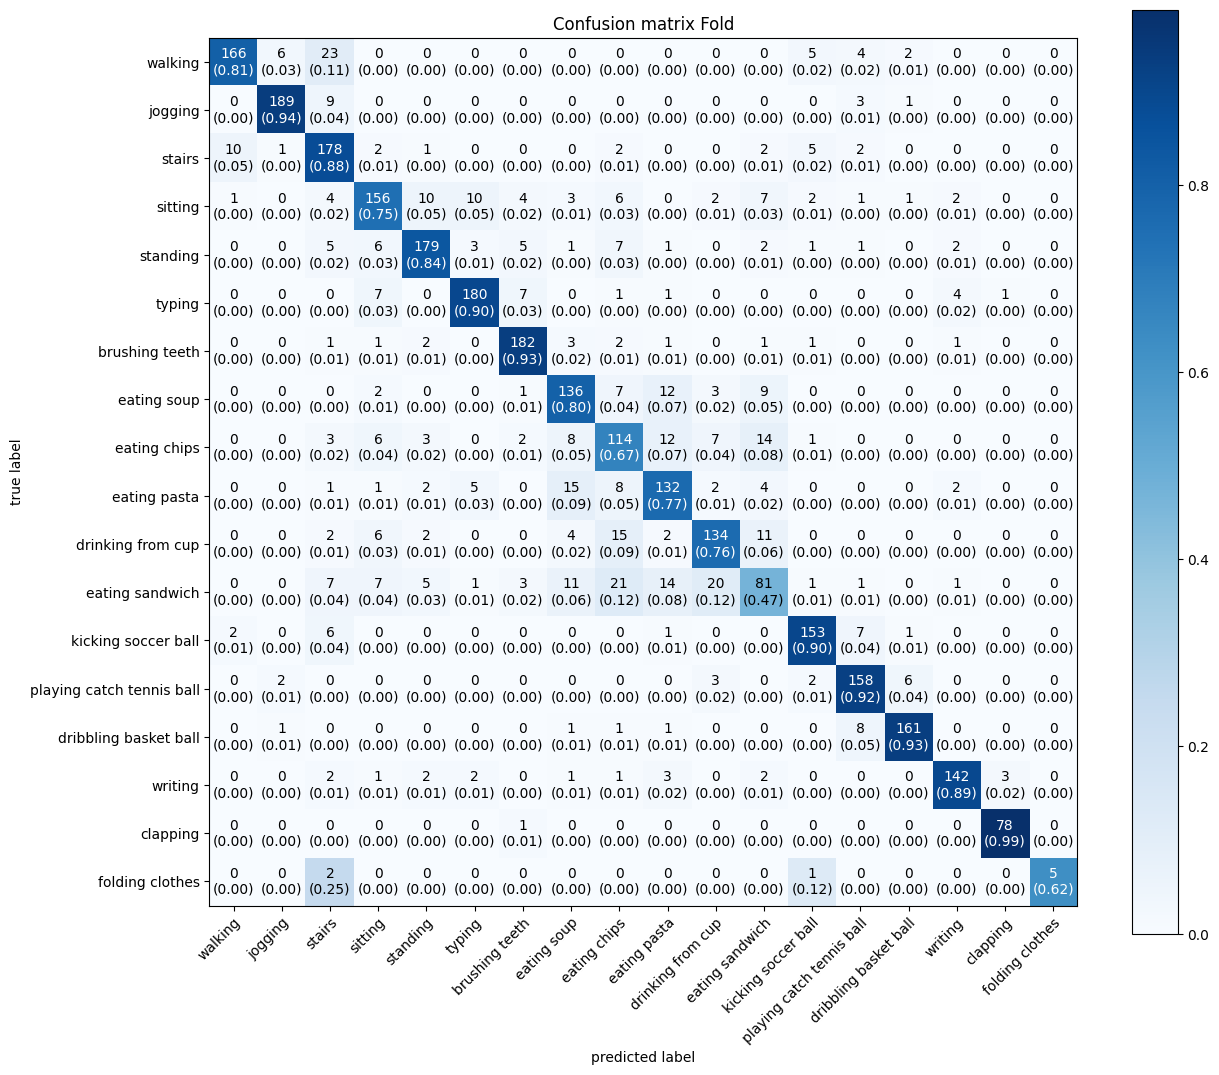

In [10]:
y_test_pred = rf_best_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_test_pred)
plotting.plot_confusion_matrix(conf_mat = conf_matrix,
                               class_names = ACTIVITY_NAMES,
                               show_normed = True,
                               figsize = (14, 12),
                               colorbar = True)
plt.title("Confusion matrix Fold")
plt.show()

#### Accuracy Per Activity

In [11]:
cm_act = pd.DataFrame(conf_matrix,
                      index=rf_best_classifier.classes_,
                      columns=rf_best_classifier.classes_)

cm_act.columns = ACTIVITY_CODES_MAP.values()
cm_act.index = ACTIVITY_CODES_MAP.values()
accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(18)],index=ACTIVITY_CODES_MAP.values())
print(accuracy_per_activity)

                                  0
walking                    0.805825
jogging                    0.935644
stairs                     0.876847
sitting                    0.746411
standing                   0.840376
typing                     0.895522
brushing teeth             0.933333
eating soup                0.800000
eating chips               0.670588
eating pasta               0.767442
drinking from cup          0.761364
eating sandwich            0.468208
kicking soccer ball        0.900000
playing catch tennis ball  0.923977
dribbling basket ball      0.930636
writing                    0.893082
clapping                   0.987342
folding clothes            0.625000


/tmp/ipykernel_2314167/4042993457.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(18)],index=ACTIVITY_CODES_MAP.values())


#### Classification Report

In [12]:
print(classification_report(y_true=y_test,
                            y_pred=y_test_pred))
print("######################################################################################")

              precision    recall  f1-score   support

           A       0.93      0.81      0.86       206
           B       0.95      0.94      0.94       202
           C       0.73      0.88      0.80       203
           D       0.80      0.75      0.77       209
           E       0.87      0.84      0.85       213
           F       0.90      0.90      0.90       201
           G       0.89      0.93      0.91       195
           H       0.74      0.80      0.77       170
           I       0.62      0.67      0.64       170
           J       0.73      0.77      0.75       172
           K       0.78      0.76      0.77       176
           L       0.61      0.47      0.53       173
           M       0.89      0.90      0.89       170
           O       0.85      0.92      0.89       171
           P       0.94      0.93      0.93       173
           Q       0.92      0.89      0.91       159
           R       0.95      0.99      0.97        79
           S       1.00    

#### Test Accuracy

In [13]:
print("test accuracy", 100 * accuracy_score(y_true=y_test, y_pred=y_test_pred))

test accuracy 82.75409836065573


## Training on Watch - Gyroscope

### Hyper parameters

In [14]:
my_param_grid = {'bootstrap': [True],
                 'n_estimators': [50, 100, 200],
                 'oob_score': [True, False],
                 'warm_start': [True, False]}
number_of_splits=5
train_size=0.8
test_size=0.2
DATA_DIR="../dataset/processed/watch/gyro"

### Initialize Dataset

In [15]:
all_watch_gyro = WISDM_Dataset(DATA_DIR)

# The approach in this analysis will be to see all the participants as a single, unified group.
# The aim of this analysis is not to examine differences between participants.
all_watch_gyro.drop('PARTICIPANT', axis = 1, inplace = True)

y = all_watch_gyro.ACTIVITY
X = all_watch_gyro.drop('ACTIVITY', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = 0.75,
                                                    test_size = 0.25,
                                                    shuffle = True,
                                                    stratify = all_watch_gyro.ACTIVITY)

# Temporarily re-unite the train lables to train dataset for further preprocessing steps.
X_train.insert(0, 'Y', y_train)

# separating y_train
y_train = X_train['Y']
X_train.drop(['Y'], axis = 1, inplace = True)

# rescaling is applied to the features that their absolute values exceed the range of ~1
rescalin_features=['XAVG', 'YAVG', 'ZAVG', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV', 'RESULTANT']
scaling_transformer = MaxAbsScaler().fit(X_train[rescalin_features])
X_train[rescalin_features] = scaling_transformer.transform(X_train[rescalin_features])

X_test = X_test.copy()
X_test[rescalin_features] = scaling_transformer.transform(X_test[rescalin_features])

# resetting the indices
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

In [16]:
X_train.columns

Index(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'Y0', 'Y1',
       'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Z0', 'Z1', 'Z2', 'Z3',
       'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'XAVG', 'YAVG', 'ZAVG', 'XABSOLDEV',
       'YABSOLDEV', 'ZABSOLDEV', 'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV', 'XVAR',
       'YVAR', 'ZVAR', 'XMFCC0', 'XMFCC1', 'XMFCC2', 'XMFCC3', 'XMFCC4',
       'XMFCC5', 'XMFCC6', 'XMFCC7', 'XMFCC8', 'XMFCC9', 'XMFCC10', 'XMFCC11',
       'XMFCC12', 'YMFCC0', 'YMFCC1', 'YMFCC2', 'YMFCC3', 'YMFCC4', 'YMFCC5',
       'YMFCC6', 'YMFCC7', 'YMFCC8', 'YMFCC9', 'YMFCC10', 'YMFCC11', 'YMFCC12',
       'ZMFCC0', 'ZMFCC1', 'ZMFCC2', 'ZMFCC3', 'ZMFCC4', 'ZMFCC5', 'ZMFCC6',
       'ZMFCC7', 'ZMFCC8', 'ZMFCC9', 'ZMFCC10', 'ZMFCC11', 'ZMFCC12', 'XYCOS',
       'XZCOS', 'YZCOS', 'XYCOR', 'XZCOR', 'YZCOR', 'RESULTANT'],
      dtype='object')

### Training

In [17]:
my_cv = StratifiedShuffleSplit(n_splits=number_of_splits, train_size=train_size, test_size=test_size)
rf_classifier = RandomForestClassifier()
rf_model_gs = GridSearchCV(estimator = rf_classifier,
                           param_grid = my_param_grid,
                           n_jobs=-1,
                           scoring = 'accuracy',
                           cv = my_cv)
rf_model_gs.fit(X_train, y_train)
rf_best_classifier = rf_model_gs.best_estimator_
print(rf_model_gs.best_params_)
print(rf_model_gs.cv_results_)
print(rf_best_classifier.get_params())

{'bootstrap': True, 'n_estimators': 200, 'oob_score': True, 'warm_start': True}
{'mean_fit_time': array([ 5.88378167,  5.77173676,  5.86284795,  5.71745467, 12.0219336 ,
       11.91874456, 11.62412748, 11.4748282 , 28.83790817, 32.25353189,
       34.56789546, 34.71826038]), 'std_fit_time': array([0.18303324, 0.07290655, 0.15706273, 0.24405009, 0.41519867,
       0.33449661, 0.23289276, 0.24579151, 1.76034227, 1.77306143,
       0.94510059, 0.60333695]), 'mean_score_time': array([0.0432785 , 0.04353371, 0.05361509, 0.04160089, 0.07594776,
       0.0737627 , 0.08074121, 0.08144026, 0.24937077, 0.17981944,
       0.14595394, 0.13917518]), 'std_score_time': array([0.00196125, 0.00260878, 0.02045983, 0.00144399, 0.00657146,
       0.00784141, 0.00761547, 0.00721943, 0.02680098, 0.03301736,
       0.01427513, 0.00131393]), 'param_bootstrap': masked_array(data=[True, True, True, True, True, True, True, True, True,
                   True, True, True],
             mask=[False, False, False,

### Evaluation

#### Train Accuracy

In [18]:
scores = cross_val_score(rf_best_classifier, X_train, y_train, cv=my_cv, scoring='accuracy')
print(list(scores))

rf_best_classifier.score(X_train, y_train)
y_train_pred = rf_best_classifier.predict(X_train)

print("######################################################################################")
print("train accuracy:", 100 * accuracy_score(y_true=y_train, y_pred=y_train_pred))
print("######################################################################################")

[0.7298951048951049, 0.7268356643356644, 0.7255244755244755, 0.7215909090909091, 0.7185314685314685]
######################################################################################
train accuracy: 100.0
######################################################################################


#### Confusion Matrix

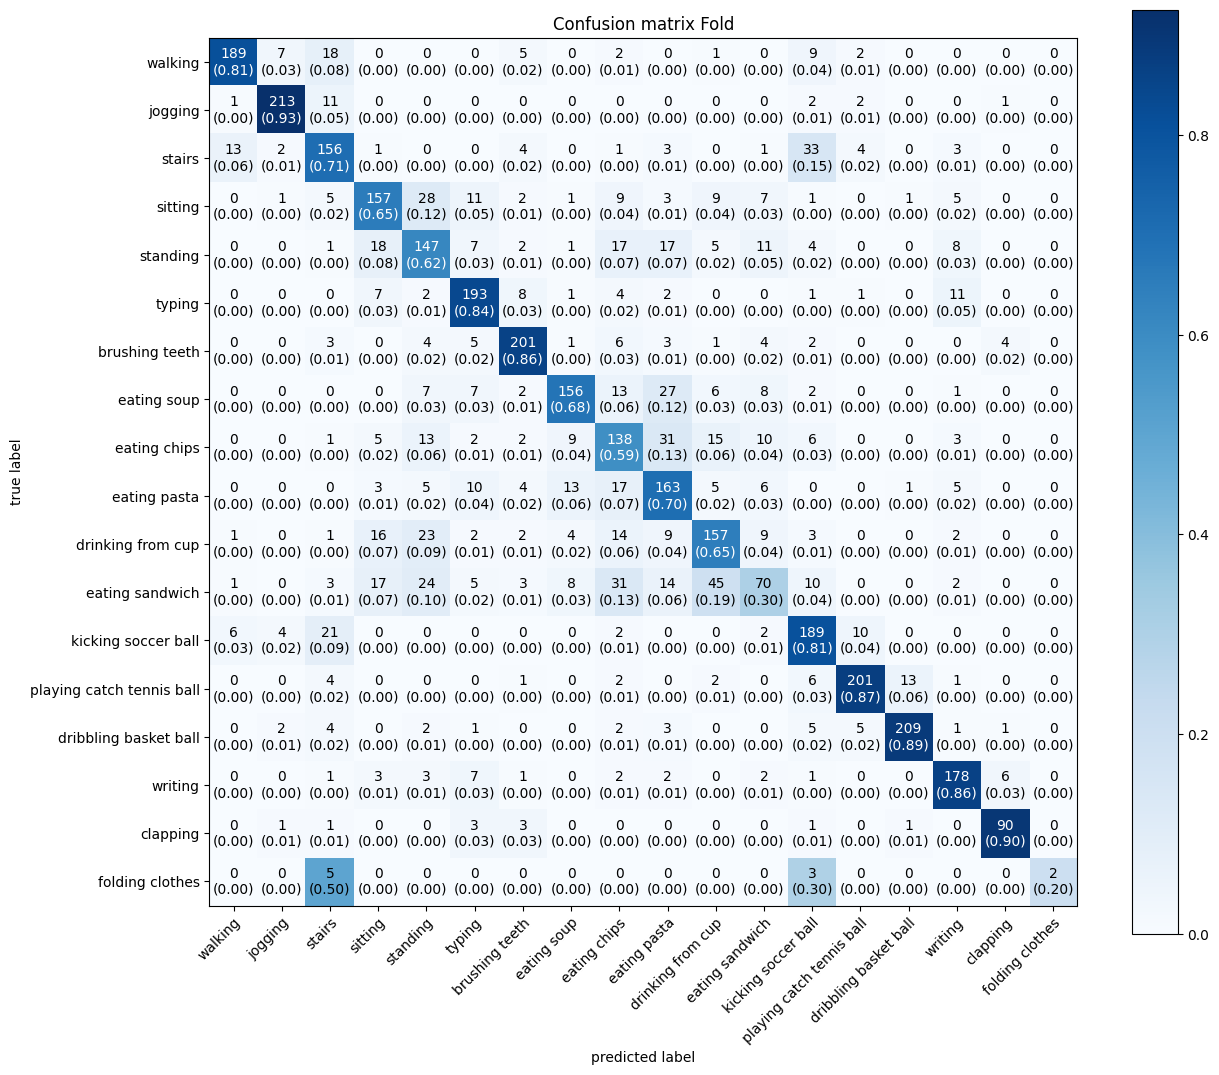

In [19]:
y_test_pred = rf_best_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_test_pred)
plotting.plot_confusion_matrix(conf_mat = conf_matrix,
                               class_names = ACTIVITY_NAMES,
                               show_normed = True,
                               figsize = (14, 12),
                               colorbar = True)
plt.title("Confusion matrix Fold")
plt.show()

#### Accuracy Per Activity

In [20]:
cm_act = pd.DataFrame(conf_matrix,
                      index=rf_best_classifier.classes_,
                      columns=rf_best_classifier.classes_)

cm_act.columns = ACTIVITY_CODES_MAP.values()
cm_act.index = ACTIVITY_CODES_MAP.values()
accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(18)],index=ACTIVITY_CODES_MAP.values())
print(accuracy_per_activity)

                                  0
walking                    0.811159
jogging                    0.926087
stairs                     0.705882
sitting                    0.654167
standing                   0.617647
typing                     0.839130
brushing teeth             0.858974
eating soup                0.681223
eating chips               0.587234
eating pasta               0.702586
drinking from cup          0.646091
eating sandwich            0.300429
kicking soccer ball        0.807692
playing catch tennis ball  0.873913
dribbling basket ball      0.889362
writing                    0.864078
clapping                   0.900000
folding clothes            0.200000


/tmp/ipykernel_2314167/4042993457.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(18)],index=ACTIVITY_CODES_MAP.values())


#### Classification Report

In [21]:
print(classification_report(y_true=y_test,
                            y_pred=y_test_pred))
print("######################################################################################")

              precision    recall  f1-score   support

           A       0.90      0.81      0.85       233
           B       0.93      0.93      0.93       230
           C       0.66      0.71      0.68       221
           D       0.69      0.65      0.67       240
           E       0.57      0.62      0.59       238
           F       0.76      0.84      0.80       230
           G       0.84      0.86      0.85       234
           H       0.80      0.68      0.74       229
           I       0.53      0.59      0.56       235
           J       0.59      0.70      0.64       232
           K       0.64      0.65      0.64       243
           L       0.54      0.30      0.39       233
           M       0.68      0.81      0.74       234
           O       0.89      0.87      0.88       230
           P       0.93      0.89      0.91       235
           Q       0.81      0.86      0.84       206
           R       0.88      0.90      0.89       100
           S       1.00    

#### Test Accuracy

In [22]:
print("test accuracy", 100 * accuracy_score(y_true=y_test, y_pred=y_test_pred))

test accuracy 73.66902701285078
